# QITE TRY

In [44]:
import numpy as np
import scipy
from scipy.optimize import minimize
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter

In [ ]:
def cost_func(coeffs_list, pauli_list, H, tau, initial_state):
    A = SparsePauliOp(pauli_list, coeffs_list).to_matrix()
    U = scipy.linalg.expm(-1j*A*tau)
    C = U - np.eye(2**N) + 1j*A

    phi = np.matmul(C, initial_state)
    
    return np.linalg.norm(phi)

In [ ]:
# SciPy minimizer routine
N = 2
pauli_list = get_pauli_list(N)
coeffs_list = np.ones(4**N)
tau = 0.01
initial_state = np.array([0.5, 0.5, 0.5, 0.5])
H = SparsePauliOp(["II"], coeffs=[1.0]).to_matrix()

result = minimize(cost_func, coeffs_list, args=(pauli_list, H, tau, initial_state), method="SLSQP")

result

In [ ]:
tau = 0.0001
initial_state_0 = np.array([1, 1, 1, 1], dtype=complex)
initial_state = initial_state_0/np.linalg.norm(initial_state_0)
H = SparsePauliOp(["II"], coeffs=[1.0]).to_matrix()
c = 1. - 2*tau*np.matmul(np.conjugate(initial_state).T, np.matmul(H, initial_state))
S = np.zeros([len(pauli_list), len(pauli_list)], dtype=complex)
b = np.zeros(len(pauli_list), dtype=complex)

for i in range(len(pauli_list)):
    sx_pauli = SparsePauliOp(pauli_list[i], 1.0).to_matrix()
    sx = np.matmul(np.conjugate(initial_state).T, np.conjugate(sx_pauli).T)
    dx_b = np.matmul(H, initial_state)
    b[i] = (-1.j/np.sqrt(c))*np.matmul(sx, dx_b)
    for j in range(len(pauli_list)):
        dx_pauli = SparsePauliOp(pauli_list[j], 1.0).to_matrix()
        dx_S = np.matmul(dx_pauli, initial_state)
        
        S[i,j] = np.matmul(sx, dx_S)

In [ ]:
def get_pauli_list(N):
    basis = ["I", "X", "Y", "Z"]
    pauli_list = []
    for i in range(len(basis)):
        for j in range(len(basis)):
            pauli_list.append(basis[i]+basis[j])
            
    return pauli_list



def get_coeffs_list_algebra(H, initial_state, tau=0.001, N = 2):
    pauli_list = get_pauli_list(N)
    c = 1. - 2*tau*np.matmul(np.conjugate(initial_state).T, np.matmul(H, initial_state))
    S = np.zeros([len(pauli_list), len(pauli_list)], dtype=complex)
    b = np.zeros(len(pauli_list), dtype=complex)
    
    for i in range(len(pauli_list)):
        sx_pauli = SparsePauliOp(pauli_list[i], 1.0).to_matrix()
        sx = np.matmul(np.conjugate(initial_state).T, np.conjugate(sx_pauli).T)
        dx_b = np.matmul(H, initial_state)
        b[i] = (-1.j/np.sqrt(c))*np.matmul(sx, dx_b)
        for j in range(len(pauli_list)):
            dx_pauli = SparsePauliOp(pauli_list[j], 1.0).to_matrix()
            dx_S = np.matmul(dx_pauli, initial_state)

            S[i,j] = np.matmul(sx, dx_S)
            
    #print(S)
    #print(b)
    return np.matmul(np.linalg.pinv(S), b)



def qite_step_algebra(H, initial_state, tau=0.001, N=2):
    pauli_list = get_pauli_list(N)
    coeffs_list = get_coeffs_list_algebra(H, initial_state, tau, N)
    #print(SparsePauliOp(pauli_list, coeffs_list))
    A = SparsePauliOp(pauli_list, coeffs_list).to_matrix()
    
    final_state = np.matmul(scipy.linalg.expm(-1j*A*tau), initial_state)
    return final_state

In [ ]:
tau = 0.001
initial_state_0 = np.array([1., 0., 0., 0.])
initial_state = initial_state_0/np.linalg.norm(initial_state_0)
H = SparsePauliOp(["XI"], coeffs=[1.0]).to_matrix()


# TEST FOR SINGLE QITE STEP

phi_A = qite_step_algebra(H, initial_state, tau)
phi_H = np.matmul(scipy.linalg.expm(-H*tau), initial_state)/np.sqrt(np.matmul(np.conjugate(initial_state).T, np.matmul(scipy.linalg.expm(-2*H*tau), initial_state)))

print("phi_A = ", phi_A)
print("||phi_A|| = ", np.linalg.norm(phi_A))
print("")
print("phi_H = ", phi_H)
print("")
print("Overlap =", np.matmul(np.conjugate(phi_A).T,phi_H))

In [ ]:
tau = 0.01
beta = 1.5
n = beta/tau
initial_state_0 = np.array([1., 0., 0., 0.], dtype=complex)
initial_state = initial_state_0/np.linalg.norm(initial_state_0)
H = SparsePauliOp(["XI"], coeffs=[1.0]).to_matrix()

state_list = [initial_state]
for i in range(int(n)-1):
    state_list.append(qite_step_algebra(H, state_list[-1], tau))

In [ ]:
#TEST FOR QITE PRINCIPLE
c = np.absolute(np.matmul(np.conjugate(initial_state).T, np.matmul(scipy.linalg.expm(-2*H*beta), initial_state)))
print(c)
phi_H = np.matmul(scipy.linalg.expm(-H*beta), initial_state)/np.sqrt(c)
print(np.linalg.norm(phi_H))
print(np.linalg.norm(state_list[-1]))

print("phi_A = ", state_list[-1]/np.linalg.norm(state_list[-1]))
print("")
print("phi_H = ", phi_H)
print("")
print("Overlap_A =", np.absolute(np.matmul(np.conjugate(state_list[-1]).T,exact_ground_state)))
print("")
print("Overlap_B =", np.absolute(np.matmul(np.conjugate(phi_H).T, exact_ground_state)))

In [ ]:
import matplotlib.pyplot as plt

exact_ground_state = np.array([1./np.sqrt(2), 0, 0, -1./np.sqrt(2)])
x = range(int(n))
y1 = []
y2 = []
for i in range(len(state_list)):
    y1.append(np.absolute(np.matmul(np.conjugate(state_list[i]).T, exact_ground_state)))
    y2.append(np.absolute(np.matmul(np.conjugate(phi_H).T, exact_ground_state)))
    
plt.plot(x, y1)
plt.plot(x, y2)

In [ ]:
### QUANTUM CIRCUIT IMPLEMENTATION

In [ ]:
import numpy as np
import scipy
from scipy.linalg import expm
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.primitives import Sampler, Estimator


def exp_value(circuit, observable, estimator=Estimator()):
    job = estimator.run(circuit, observable)
    
    return job.result().values[0]



def get_pauli_list(N=2):
    basis = ["I", "X", "Y", "Z"]
    pauli_list = []
    for i in range(len(basis)):
        for j in range(len(basis)):
            pauli_list.append(basis[i]+basis[j])
            
    return pauli_list



def get_coeffs_list(H, initial_circuit, tau=0.001, N = 2):
    pauli_list = get_pauli_list(N)
    c = 1. - 2.*tau*exp_value(initial_circuit, H)
    #print(c)
    S = np.ones([len(pauli_list), len(pauli_list)], dtype=complex)
    b = np.zeros(len(pauli_list), dtype=complex)
    
    for k in range(len(pauli_list)):
        b[k] = (0-1j/np.sqrt(c))*exp_value(initial_circuit, (SparsePauliOp([pauli_list[k]]).dot(H)))
        for l in range(len(pauli_list)):
            #S[k,l] = np.around(exp_value(initial_circuit, (SparsePauliOp([pauli_list[k]]).dot(SparsePauliOp([pauli_list[l]])))))
            S[k,l] = exp_value(initial_circuit, (SparsePauliOp([pauli_list[k]]).dot(SparsePauliOp([pauli_list[l]]))))

    #print(S)
    #print(b)
    return np.linalg.solve(S+S.T, -b)



def qite_step(H, circuit, tau=0.001, N=2):
    pauli_list = get_pauli_list(N)
    coeffs_list = get_coeffs_list(H, circuit, tau, N)
    A = SparsePauliOp(pauli_list, coeffs_list)
    print(A)
    print(A.adjoint().to_matrix())
    
    U = Operator(expm(0.-1.j*A.to_matrix()*tau))
    print(U.is_unitary())
    
    #circuit.append(U, [0,1])
    return U

# VarQITE Implementation on LMG

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

def twolocal(n, gates=["ry"], entanglement="linear", reps=1, par_name="x", par = None):
    
    
    def lin_entanglement(qc):
        n = qc.num_qubits
        for qubit in range(0, n-1):
            qc.cx(qubit, qubit+1)
            
    def single_rep(qc, gates, par):
        n = qc.num_qubits
        for i in range(0, n):
            for gate in gates:
                if gate == "ry":
                    qc.ry(par[i], i)

    #if par == None:
    #    par = [Parameter("{}_{}".format(par_name,i)) for i in range(0,n*len(gates)*(reps+1))]
    qc = QuantumCircuit(n)

    
    single_rep(qc, gates, par[:(n*len(gates))])
    
    for rep in range(1, reps+1):
        if entanglement == "linear":
            lin_entanglement(qc)
        single_rep(qc, gates, par[n*len(gates)*(rep):n*len(gates)*(rep+1)])

    return qc

In [2]:
import numpy as np
from qiskit.algorithms.time_evolvers import TimeEvolutionProblem, VarQITE
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.primitives import Estimator
from qiskit.circuit.library import TwoLocal


N = 2
B = 0.7
gy = 0.8
ansatz = TwoLocal(N, "ry", "cx", entanglement="linear", reps=2)
phi_list = [Parameter('phi_{}'.format(i)) for i in range(ansatz.num_parameters)]
for i in range(len(phi_list)):
    phi_list[i] = 2*np.pi*np.random.uniform()
#phi_list[2] = np.pi/2-0.7
#phi_list[3] = np.pi+0.9
H = SparsePauliOp(["XX", "YY", "IZ", "ZI"], [-1./N, -gy/N, -B, -B])
beta = 5

problem = TimeEvolutionProblem(H, beta)


qite = VarQITE(ansatz, phi_list)
result = qite.evolve(problem)

C:\Users\39339\AppData\Local\Temp\ipykernel_5308\3731865685.py:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.time_evolvers import TimeEvolutionProblem, VarQITE


In [3]:
print(result)

{   'aux_ops_evaluated': None,
    'evolved_state': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000002BB76E660D0>,
    'observables': [],
    'parameter_values': array([[4.71463762, 2.19053332, 1.34097524, 3.31246904, 1.5378914 ,
        1.67485105],
       [4.71930729, 2.17437831, 1.3439636 , 3.31383228, 1.53054211,
        1.67492115],
       [4.72394989, 2.15829583, 1.34692291, 3.31524139, 1.52321011,
        1.67509164],
       ...,
       [5.2552628 , 1.53587329, 1.81896906, 3.28382418, 0.87912342,
        1.5517563 ],
       [5.25542934, 1.5359946 , 1.8191266 , 3.28366857, 0.87899195,
        1.5514739 ],
       [5.25559502, 1.53611523, 1.81928335, 3.28351369, 0.87886113,
        1.55119288]]),
    'times': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.

Ansatz used


C:\Users\39339\anaconda3\envs\MyQiskitEnv\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


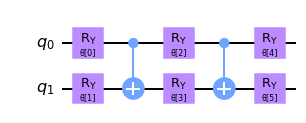

Initial circuit


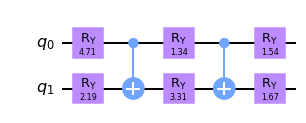

Final circuit


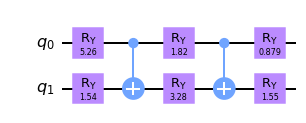

In [4]:
print("Ansatz used")
display(ansatz.decompose().draw("mpl"))
print("Initial circuit")
display(twolocal(n=N, gates=["ry"], reps=2, par = result.parameter_values[0]).draw("mpl"))
print("Final circuit")
display(result.evolved_state.decompose().draw("mpl"))

In [19]:
initial_state = Statevector([1.,0.,0.,0.]).evolve(twolocal(n=N, gates = ["ry"], reps=2, par = result.parameter_values[0]))
final_state = Statevector([1.,0.,0.,0.]).evolve(result.evolved_state)

print(initial_state)
print(final_state)

Statevector([3.74939946e-33+0.j, 6.12323400e-17+0.j, 6.12323400e-17+0.j,
             1.00000000e+00+0.j],
            dims=(2, 2))
Statevector([9.99999998e-05+0.j, 6.13718437e-17+0.j, 6.13345628e-17+0.j,
             9.99999995e-01+0.j],
            dims=(2, 2))


In [57]:
from qiskit.quantum_info import Operator
from qiskit.opflow import X, Y, Z, I
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np


def ClassicalLMGH(Natoms, gy, B):  # Spin_Magnet_Hamilton_class
    """
    Returns the hamiltonian operator of LMG model given its parameters.

        Parameters:
                Natoms(int): number of qubits considered
                B(float): Magnetic field intensity
                gy(float): parameter of hamiltonian

        Returns:
                Hamiltonian(operator): Operator of the hamiltonian
    """

    # initialize 0-dimensional Operators
    field = Operator([0])
    spin = Operator([0])

    # cycle over all qubits
    for i in range(Natoms):

        # Adds the spin field interaction for each atom
        field = field ^ I
        field -= B * ((I ^ i) ^ Z)

        # Adds a qubit to the spin part
        spin = spin ^ I

        # implementation for the i-th qubit
        # of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spin -= 1 / Natoms * ((I ^ j) ^ X ^ (I ^ (i - j - 1)) ^ X)
            spin -= 1 / Natoms * gy * ((I ^ j) ^ Y ^ (I ^ (i - j - 1)) ^ Y)
    return spin + field



def ClassicalDiagonalizer(H):  # class_par_H_diagonalizer
    """
    Diagonalizer of parametrized H.

        Parameters:
                H(list of matrices): The matrices to be diagonalizedt, the matrices must be Hermitian
        Returns:
                EigenValues: list containing Eigenvalues
                EigenStates: list containing Eigenstates
                MinEigenValues: list containing "Ground state" value
                MinEigenStates:    list cointaining "Ground state"
                ExecTime: list containing the time it took to diagonalize the matrix
    """
    EigenValues = [[] * 2 ** (H[0].num_qubits) for _ in range(len(H))]
    EigenStates = [[] * 2 ** (H[0].num_qubits) for _ in range(len(H))]
    MinEigenState = []
    MinEigenValue = []
    ExecTime = []
    for i in range(len(H)):
        start = time.time()
        # Classical diagonalizer for Hermitian matrix. Eig vals are sorted automatically
        w, v = np.linalg.eigh(H[i])
        for j in range(len(w)):
            EigenValues[i].append(w[j])
            EigenStates[i].append(v[:, j])
        MinEigenValue.append(w[0])
        MinEigenState.append(v[:, 0])
        ExecTime.append(time.time() - start)
    return EigenValues, EigenStates, MinEigenValue, MinEigenState, ExecTime

In [58]:
H_exact = [ClassicalLMGH(N, gy, B)]
EigenValues, EigenStates, MinEigenValue, MinEigenState, ExecTime = ClassicalDiagonalizer(H_exact)
print("Numerical obtained eigenstate = ", MinEigenState)
print("")
print("VarQITE obtained eigenstate = ", final_state)
print("")
print("Numerical obtained eigenvalue =", MinEigenValue)
print("")
print("VarQITE obtained eigenvalue = ", final_state.expectation_value(H))

Numerical obtained eigenstate =  [array([-0.99936447-0.j,  0.        +0.j,  0.        +0.j, -0.03564618+0.j])]

VarQITE obtained eigenstate =  Statevector([0.50049997+0.j, 0.50019974+0.j, 0.50019936+0.j,
             0.49909979+0.j],
            dims=(2, 2))

Numerical obtained eigenvalue = [-1.40356688476182]

VarQITE obtained eigenvalue =  (-0.5022786263741992+0j)


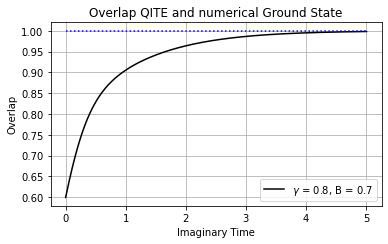

In [8]:
initial_state = Statevector([1.,0.,0.,0.]).evolve(twolocal(n=N, gates = ["ry"], reps=2, par = result.parameter_values[0]))
exact_ground_state = Statevector(MinEigenState[0])
x = result.times
y1 = []
y2 = []

for i in range(len(x)):
    #qc = QuantumCircuit(2)
    #qc.append(twolocal(n=2, gates = ["ry"], reps=2, par = result.parameter_values[i]), [0,1])
    state = Statevector([1.,0.,0.,0.]).evolve(twolocal(n=N, reps=2, par = result.parameter_values[i]))
    y1.append(np.absolute(state.inner(exact_ground_state)))
    y2.append(1.)

plt.rcParams["figure.figsize"] = [5.50, 3.50]
plt.rcParams["figure.autolayout"] = True

    
gylabel = "$\gamma$ = {gy:.1f}, B = {B:.1f}"

plt.title("Overlap QITE and numerical Ground State")


plt.plot(x, y1, color="black", label=gylabel.format(gy=gy,B=B))
plt.plot(x, y2, color="blue", ls="dotted")

plt.ylabel('Overlap')
plt.xlabel('Imaginary Time')


# Line of codes to avoid repeating labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid()
plt.show()

# QMETTS Algorithm

In [113]:
from qiskit.primitives import Estimator



def num_th_average(H, beta):
    N = H[0].num_qubits
    EigenValues, EigenStates, MinEigenValue, MinEigenState, ExecTime = ClassicalDiagonalizer(H)
    Z = 0
    rho = np.zeros([2**N, 2**N], dtype=complex)
    for i in range(len(EigenValues[0])):
        Z += np.exp(- beta*EigenValues[0][i])
        rho += np.exp(- beta*EigenValues[0][i])*np.matmul(np.atleast_2d(EigenStates[0][i]).T,np.atleast_2d(EigenStates[0][i]))
    rho = rho/Z
    exact_average = np.trace(np.matmul(H[0].to_matrix(), rho))
    
    return exact_average



def exp_value(circuit, observable, estimator=Estimator()):
    job = estimator.run(circuit, observable)
    
    return job.result().values[0]



def QITE(H, parameter_list, ansatz, tau):
    
    problem = TimeEvolutionProblem(H, tau)
    qite = VarQITE(ansatz, parameter_list)
    result = qite.evolve(problem)
    
    return result



def state_to_par(label = "++", num_params = 6):
    
    par_list = np.zeros(num_params)
    if label == "++":
        par_list[-2] = np.pi/2
        par_list[-1] = np.pi/2
    elif label == "+-":
        par_list[-2] = np.pi/2
        par_list[-1] = -np.pi/2    
    elif label == "-+":
        par_list[-2] = -np.pi/2
        par_list[-1] = np.pi/2
    elif label == "--":
        par_list[-2] = -np.pi/2
        par_list[-1] = -np.pi/2

    return par_list



def random_state_label():
    choice = np.random.randint(4)
    if choice == 0:
        state_label = "++"
    elif choice == 1:
        state_label = "+-"
    elif choice == 2:
        state_label = "-+"
    elif choice == 3:
        state_label = "--"
        
    return state_label



def th_average_step(H, state_label, ansatz, beta):
    
    tau = beta/2.
    parameter_list = state_to_par(state_label)
    
    result = QITE(H, parameter_list, ansatz, tau)    
    final_state = Statevector([1.,0.,0.,0.]).evolve(result.evolved_state)

    measure = exp_value(result.evolved_state, H)

    return final_state, measure



def th_average(H, ansatz, beta, shots = 100):
    final_state_list = []
    measure_list = []
    for i in range(shots):
        state_label = random_state_label()
        result = th_average_step(H, state_label, ansatz, beta)
        final_state_list.append(result[0])
        measure_list.append(result[1])
        
    return final_state_list, measure_list

In [114]:
N =2
B = 0.7
gy = 0.8
beta = 0.5

H_exact = [ClassicalLMGH(N, gy, B)]



num_th_average(H_exact, beta)

(-0.6300818520905662+0j)

In [119]:
shots = 50
beta = 0.5
H = SparsePauliOp(["XX", "YY", "IZ", "ZI"], [-1./N, -gy/N, -B, -B])
ansatz = TwoLocal(N, "ry", "cx", entanglement="linear", reps=2)



final_state_list, measure_list = th_average(H, ansatz, beta, shots)

In [120]:
print("thermal average = ", np.mean(measure_list))
print("standard deviation = ", np.std(measure_list))

thermal average =  -0.595000311317587
standard deviation =  0.35185063113342435


In [144]:
N =2
B = 0.7
gy = 0.8
beta_list = [2.5, 3.,]
shots = 100

H_exact = [ClassicalLMGH(N, gy, B)]
H = SparsePauliOp(["XX", "YY", "IZ", "ZI"], [-1./N, -gy/N, -B, -B])
ansatz = TwoLocal(N, "ry", "cx", entanglement="linear", reps=2)



QITE_th_averages = []
QITE_stds = []
num_th_averages = []
for beta in beta_list:
    final_state_list, measure_list = th_average(H, ansatz, beta, shots)
    QITE_th_averages.append(np.mean(measure_list))
    QITE_stds.append(np.std(measure_list))
    
    
    num_th_averages.append(num_th_average(H_exact, beta))
    print("one done")

one done
one done


C:\Users\39339\anaconda3\envs\MyQiskitEnv\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


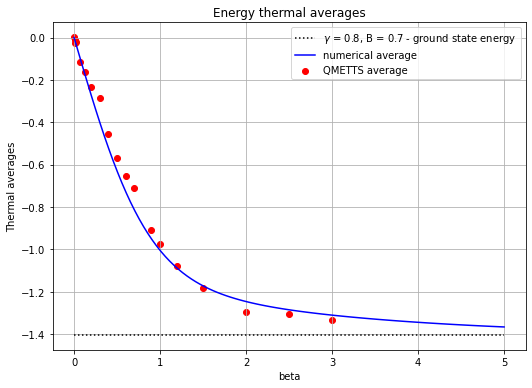

In [154]:
EigenValues, EigenStates, MinEigenValue, MinEigenState, ExecTime = ClassicalDiagonalizer(H_exact)

x = np.linspace(0., 5., 100)

ground_state_energy = []
num_th_averages = []
for beta in x:
    ground_state_energy.append(MinEigenValue[0])
    num_th_averages.append(num_th_average(H_exact, beta))
    
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True

    
gylabel = "$\gamma$ = {gy:.1f}, B = {B:.1f} - ground state energy"

plt.title("Energy thermal averages")


plt.plot(x, ground_state_energy, color="black", ls="dotted", label=gylabel.format(gy=gy,B=B))
plt.plot(x, num_th_averages, color="blue", label = "numerical average")
#plt.scatter(beta_list, QITE_th_averages, color="red", label = "QMETTS average")
plt.scatter(FINAL_BETA_LIST, FINAL_THERMAL_AVERAGES, color="red", label = "QMETTS average")


plt.ylabel('Thermal averages')
plt.xlabel('beta')


# Line of codes to avoid repeating labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid()
plt.show()

In [146]:
print(beta_list)
print(QITE_th_averages)
print(QITE_stds)

[2.5, 3.0]
[-1.3038880251444231, -1.3344910659946299]
[0.07880514741742126, 0.07046475406072562]


In [152]:
len(FINAL_THERMAL_AVERAGES)

18

In [153]:
FINAL_BETA_LIST = [0.002, 0.0066, 0.013, 0.02, 0.066, 0.13, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1., 1.2, 1.5, 2., 2.5, 3.]
FINAL_THERMAL_AVERAGES = [0.00105332581330518,
 -0.02752334390461963,
 -0.011714597440540032,
 -0.022798373416008433,
 -0.11499235657133709,
 -0.1650751468122611,
 -0.23383945885230625,
 -0.2853876978720102, 
 -0.45555805661007215,
 -0.5666473794701733,
 -0.6519949730184592,
 -0.7097642635599528,
 -0.9081446257276135,     
 -0.9768282992862122,
 -1.0801798353973835,
 -1.1845067875762707,
 -1.2957786226846861,
 -1.3038880251444231, 
 -1.3344910659946299]


FINAL_STDS = [0.49998751679675074,
 0.49958491084815554,
 0.4999291273529097,
 0.4998628083235871,
 0.49579641395448065,
 0.485497175484528,
 0.4688814233535053,
 0.4400724821866857,
 0.40226492614732107,
 0.3541280052716492,
 0.30528478481951259,
 0.2468413066257637,
 0.1490907459029607,             
 0.10528478481951259,
 0.10528478481951259,
 0.03278287173921851,
 0.07066360380399264,
 0.07880514741742126,
 0.07046475406072562]